In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm
import torch

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
# from new_pokie import pokie, pokie_bootstrap
from pokie import pokie, pokie_bootstrap, get_device, pokie_with_convergence_estimate, pokie_test

Take away from this experiment

Unlike PQMass, the data is not always 

In [2]:
curr_num_runs = 50

# Sample from GMM

In [3]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 20 Dimension

In [4]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 20
n_truth_samples = 1000  # Number of ground truth samples
num_posterior_samples = 1000  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 33.73it/s]


In [5]:
list_of_distance_metrics = ['canberra', 'braycurtis', 'seuclidean', 'euclidean', 'cosine', 'correlation', 'cityblock', 'chebyshev']
# list_of_distance_metrics = []

# Assume you have a function pokie(gt_norm, posterior_norm, num_runs)
# that returns (raw_probs, calibrated_probs, n_over_N_vals).
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
posterior_norm   = torch.tensor(models_normalized, dtype=torch.float32, device=device)
gt_norm = torch.tensor(truth_data_normalized,   dtype=torch.float32, device=device)

Using device: mps


In [6]:
# Shape of posterior_norm
print(f'posterior_norm shape: {posterior_norm.shape}')  # Should be (n_truth_samples, n_dimensions)
# Shape of gt_norm
print(f'gt_norm shape: {gt_norm.shape}')  # Should be (num_models, n_truth_samples, num_posterior_samples, n_dimensions)

posterior_norm shape: torch.Size([21, 1000, 1000, 20])
gt_norm shape: torch.Size([1000, 20])


In [7]:
# Define a text file to save the results
results_file = f"Test_Pokie_Result_GMM_Curr_Num_Runs_{curr_num_runs}.txt"

Pokie MC runs: 100%|██████████| 50/50 [06:29<00:00,  7.78s/it]


Distance Metric: canberra
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.04735052 0.04751952 0.04772785 0.04763894 0.04775423 0.04780896
 0.04787664 0.04764564 0.04753013 0.04763641 0.04774422 0.04744086
 0.04774549 0.04773472 0.04760561 0.04740911 0.04753094 0.04757154
 0.04769549 0.04754664 0.04748653]
Calibrated Pokie: [0.49781975 0.49959657 0.5017868  0.5008521  0.5020641  0.50263953
 0.50335115 0.5009225  0.4997081  0.50082546 0.5019589  0.49876952
 0.50197226 0.50185895 0.50050163 0.4984358  0.49971658 0.5001434
 0.5014466  0.49988163 0.49924964]


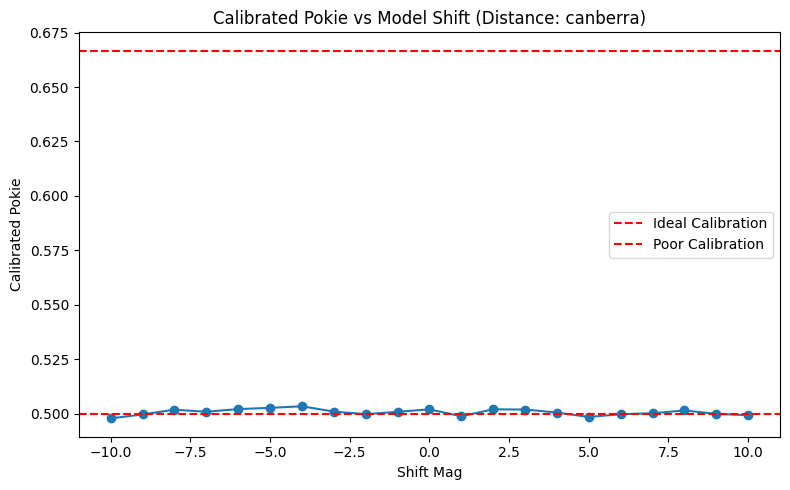

Pokie MC runs: 100%|██████████| 50/50 [06:18<00:00,  7.57s/it]


Distance Metric: braycurtis
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.04875683 0.05648875 0.06249194 0.05462657 0.04690207 0.04577406
 0.04566461 0.0455435  0.04539846 0.04606166 0.04567607 0.04581343
 0.04553519 0.04549108 0.04576169 0.0456873  0.04554034 0.04565884
 0.04561277 0.04578053 0.04573425]
Calibrated Pokie: [0.53462386 0.61940515 0.68523085 0.59898627 0.5142862  0.5019175
 0.5007174  0.4993894  0.49779895 0.50507104 0.50084305 0.50234926
 0.49929821 0.49881455 0.5017818  0.50096613 0.49935472 0.5006541
 0.50014883 0.5019885  0.5014809 ]


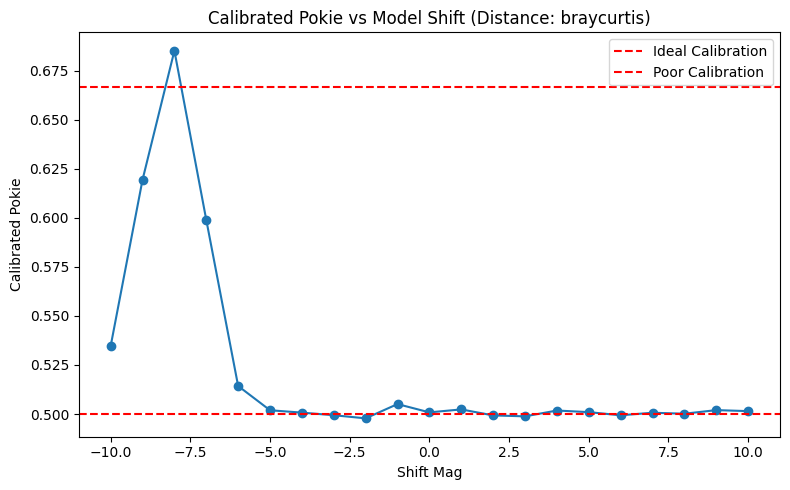

Pokie MC runs: 100%|██████████| 50/50 [05:48<00:00,  6.96s/it]


Distance Metric: seuclidean
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.04767949 0.04750609 0.04767364 0.047846   0.04796314 0.04757436
 0.04731893 0.04763919 0.04767503 0.04755799 0.04775336 0.04764238
 0.04764077 0.0477787  0.0475686  0.04755663 0.04754077 0.04749314
 0.04755326 0.04760356 0.04743497]
Calibrated Pokie: [0.50162023 0.49979594 0.50155866 0.503372   0.5046044  0.5005142
 0.49782696 0.50119627 0.5015733  0.500342   0.5023974  0.5012299
 0.5012128  0.502664   0.5004536  0.5003277  0.5001608  0.49965972
 0.50029224 0.50082135 0.4990477 ]


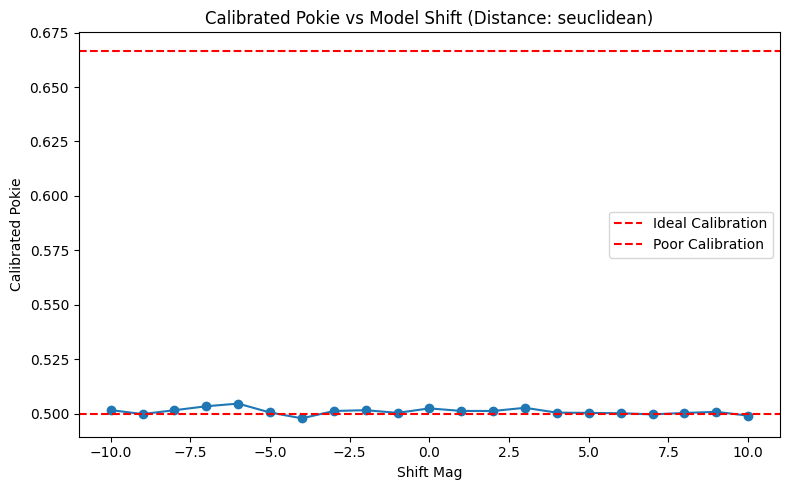

Pokie MC runs: 100%|██████████| 50/50 [00:05<00:00,  8.96it/s]


Distance Metric: euclidean
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.04347302 0.0432842  0.04331089 0.04332776 0.04366723 0.04426086
 0.04629179 0.04996899 0.05435662 0.05708728 0.0577962  0.0575974
 0.05591222 0.0512884  0.04677389 0.04434546 0.04359878 0.04353304
 0.04353483 0.04326016 0.04333099]
Calibrated Pokie: [0.5010502  0.4988739  0.4991815  0.4993759  0.50328845 0.51013035
 0.5335379  0.5759196  0.62648946 0.6579618  0.6661325  0.6638412
 0.64441866 0.5911265  0.5390943  0.5111055  0.5024996  0.5017419
 0.5017625  0.4985968  0.49941307]


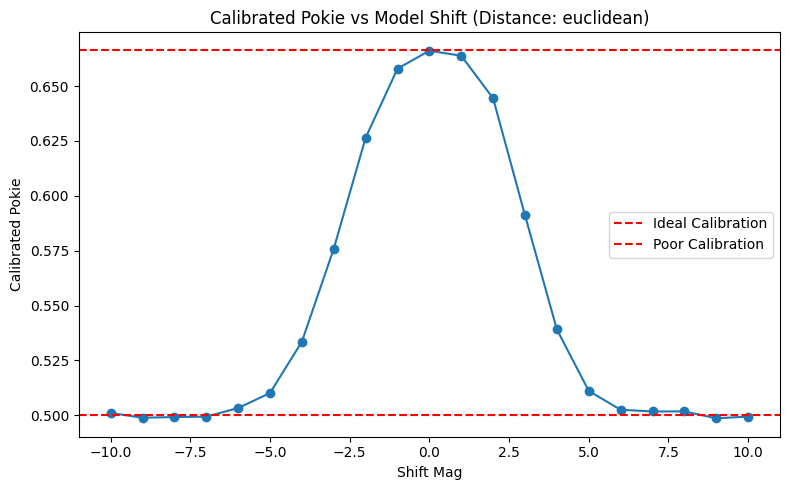

Pokie MC runs: 100%|██████████| 50/50 [06:01<00:00,  7.23s/it]


Distance Metric: cosine
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.05274672 0.05489347 0.05556839 0.0519939  0.04763219 0.04606746
 0.0459471  0.04595912 0.04623454 0.04615024 0.0460257  0.04599518
 0.04616218 0.04618331 0.04595639 0.04613147 0.04597076 0.04601973
 0.0460989  0.04612647 0.04613683]
Calibrated Pokie: [0.5732622  0.5965935  0.60392874 0.5650804  0.5176765  0.5006707
 0.4993626  0.4994932  0.5024865  0.50157034 0.50021684 0.4998851
 0.5017001  0.50192976 0.49946353 0.5013664  0.49961966 0.5001519
 0.5010124  0.501312   0.50142455]


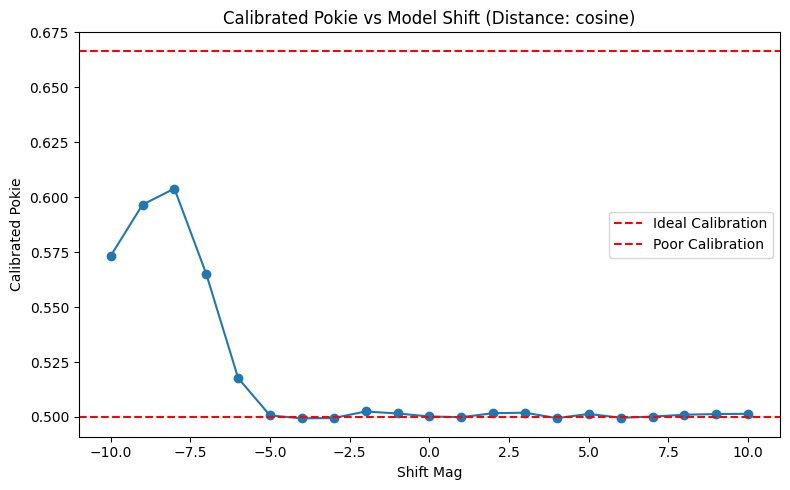

Pokie MC runs: 100%|██████████| 50/50 [07:23<00:00,  8.86s/it]


Distance Metric: correlation
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.04760682 0.04753055 0.04765389 0.04761853 0.04763523 0.04759561
 0.04771338 0.04762489 0.04780034 0.04774769 0.04761546 0.04749594
 0.04737474 0.04762979 0.04778627 0.04759455 0.04767355 0.04748895
 0.04738946 0.04766106 0.04776327]
Calibrated Pokie: [0.51648605 0.5156586  0.5169967  0.51661307 0.51679426 0.51636434
 0.5176421  0.51668215 0.5185855  0.51801443 0.5165798  0.51528305
 0.5139682  0.5167353  0.5184329  0.5163529  0.51721007 0.51520723
 0.5141278  0.5170744  0.51818335]


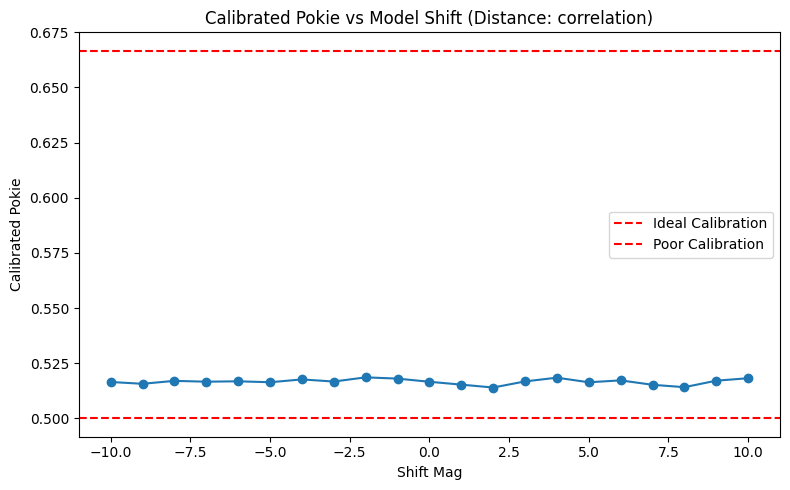

Pokie MC runs: 100%|██████████| 50/50 [05:59<00:00,  7.20s/it]


Distance Metric: cityblock
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.04787412 0.0473674  0.04765162 0.04787349 0.04759392 0.04770755
 0.04773346 0.04751404 0.04743689 0.04766293 0.04761916 0.04776701
 0.04755723 0.04760966 0.04763943 0.047712   0.04753044 0.04750457
 0.0475437  0.047456   0.04764533]
Calibrated Pokie: [0.5029311  0.4976079  0.5005937  0.50292444 0.4999875  0.50118124
 0.5014534  0.49914825 0.49833784 0.5007125  0.5002527  0.5018059
 0.49960214 0.50015295 0.5004656  0.50122803 0.4993207  0.49904895
 0.49945995 0.49853858 0.5005276 ]


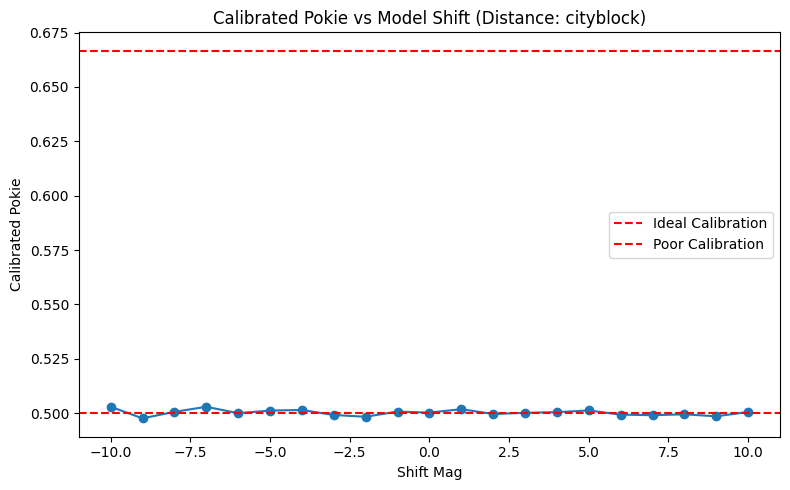

Pokie MC runs: 100%|██████████| 50/50 [06:28<00:00,  7.76s/it]


Distance Metric: chebyshev
Shift Magnitude: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Raw Pokie: [0.05497814 0.05292004 0.05045746 0.04814582 0.0465471  0.04550969
 0.04513356 0.04485686 0.04471104 0.04485466 0.04483432 0.04471123
 0.04478508 0.04465751 0.0451029  0.04529415 0.0464193  0.04831352
 0.05040353 0.05267628 0.05468782]
Calibrated Pokie: [0.61542547 0.59238714 0.564821   0.5389445  0.52104837 0.50943565
 0.50522524 0.50212777 0.5004955  0.5021032  0.5018755  0.50049764
 0.5013243  0.4998962  0.50488204 0.5070229  0.51961774 0.5408217
 0.5642172  0.5896584  0.6121756 ]


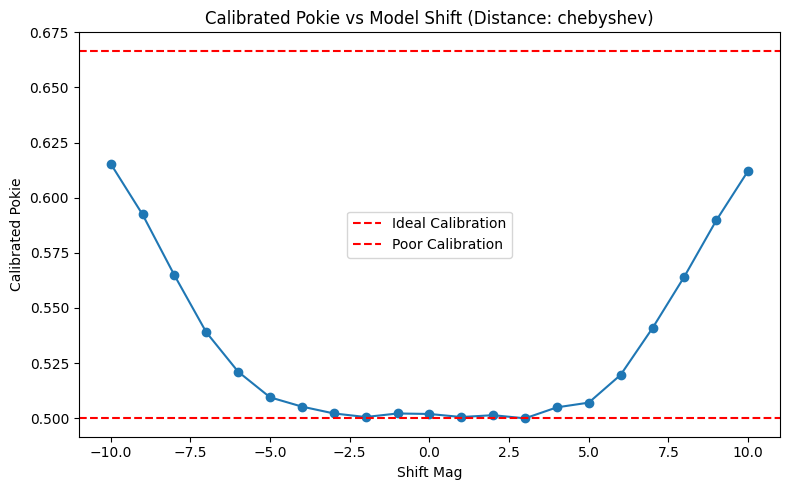

In [8]:
# -------------------------------
# 4. Pokie Evaluation
# -------------------------------
# Open the file in write mode
with open(results_file, "a") as f:
    for distance_metric in list_of_distance_metrics:
        try:
            results, calibrated, n_over_N_vals = pokie_test(
                gt_norm, posterior_norm, num_runs=curr_num_runs, distance_metric=distance_metric
            )
        except Exception as e:
            print(f"Error with distance metric '{distance_metric}': {e}")
            continue

        # Convert results, calibrated, n_over_N_vals back to numpy arrays
        results = results.cpu().numpy()
        calibrated = calibrated.cpu().numpy()
        n_over_N_vals = n_over_N_vals.cpu().numpy()
        
        print(f"Distance Metric: {distance_metric}")
        print("Shift Magnitude:", shift_magnitudes)
        print("Raw Pokie:", results)
        print("Calibrated Pokie:", calibrated)

        # Write the results as follows --> Distance Metric | Calibrated Pokie
        for noise_level, cal_pokie in zip(shift_magnitudes, calibrated):
            f.write(f"\n{distance_metric} | {noise_level} | {cal_pokie}\n")

        # -------------------------------
        # 5. Plotting
        # -------------------------------
        plt.figure(figsize=(8,5))
        plt.plot(shift_magnitudes, calibrated, marker='o')
        plt.xlabel('Shift Mag')
        plt.ylabel('Calibrated Pokie')
        plt.title('Calibrated Pokie vs Model Shift (Distance: {})'.format(distance_metric))
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='r', linestyle='--', label='Poor Calibration')
        plt.legend()
        plt.tight_layout()
        plt.show()

{'canberra': {-10.0: 0.4978197515010834, -9.0: 0.49959656596183777, -8.0: 0.5017868280410767, -7.0: 0.500852108001709, -6.0: 0.5020641088485718, -5.0: 0.5026395320892334, -4.0: 0.5033511519432068, -3.0: 0.5009225010871887, -2.0: 0.4997080862522125, -1.0: 0.5008254647254944, 0.0: 0.5019589066505432, 1.0: 0.49876952171325684, 2.0: 0.5019722580909729, 3.0: 0.5018589496612549, 4.0: 0.5005016326904297, 5.0: 0.4984357953071594, 6.0: 0.499716579914093, 7.0: 0.5001434087753296, 8.0: 0.5014466047286987, 9.0: 0.4998816251754761, 10.0: 0.4992496371269226}, 'braycurtis': {-10.0: 0.5346238613128662, -9.0: 0.6194051504135132, -8.0: 0.6852308511734009, -7.0: 0.5989862680435181, -6.0: 0.5142862200737, -5.0: 0.5019174814224243, -4.0: 0.5007174015045166, -3.0: 0.4993894100189209, -2.0: 0.49779894948005676, -1.0: 0.5050710439682007, 0.0: 0.5008430480957031, 1.0: 0.5023492574691772, 2.0: 0.49929821491241455, 3.0: 0.49881455302238464, 4.0: 0.5017818212509155, 5.0: 0.5009661316871643, 6.0: 0.499354720115661

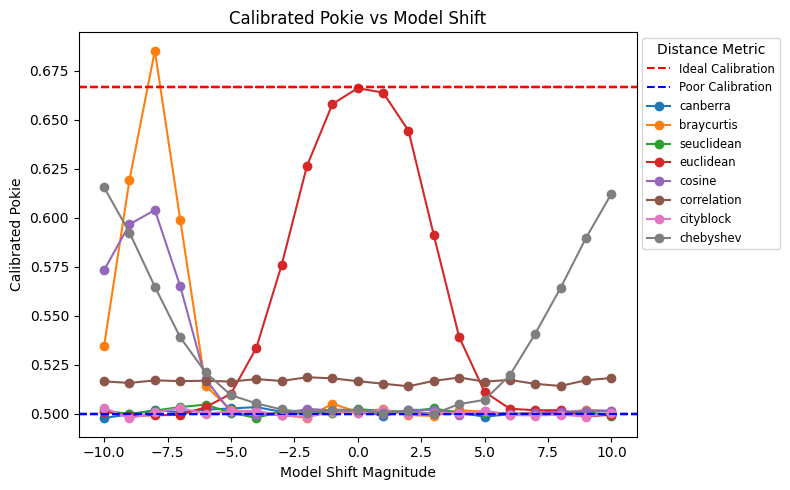

In [11]:
# Load in the data for all the distance metrics
data = {}
results_file = '/Users/sammysharief/Downloads/Pokie/notebook/Distance_Exp/Pokie_Result_GMM_Curr_Num_Runs_50.txt'
# Read the results file and store the data
with open(results_file, "r") as f:
    for line in f:
        if line.strip():  # Skip empty lines
            parts = line.strip().split('|')
            if len(parts) == 3:
                distance_metric = parts[0].strip()
                noise_level = float(parts[1].strip())
                calibrated_pokie = float(parts[2].strip())
                
                if distance_metric not in data:
                    data[distance_metric] = {}
                data[distance_metric][noise_level] = calibrated_pokie

print(data)
print(data.keys())
plt.figure(figsize=(8, 5))
# Plot the data for each key in data
for distance_metric, noise_data in data.items():
    noise_levels = sorted(noise_data.keys())
    calibrated_values = [noise_data[nl] for nl in noise_levels]

    if distance_metric == 'canberra':
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='b', linestyle='--', label='Poor Calibration')
    else:
        plt.axhline(y=2/3, color='r', linestyle='--')
        plt.axhline(y=1/2, color='b', linestyle='--')
    
    
    plt.plot(noise_levels, calibrated_values, marker='o', label=distance_metric)
    plt.xlabel('Model Shift Magnitude')
    plt.ylabel('Calibrated Pokie')
    plt.title(f'Calibrated Pokie vs Model Shift')
    
# Put Legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Distance Metric')
plt.tight_layout()
plt.savefig(f'{project_root}/Plots/Different_Distance_Metrics/Pokie_GMM_Different_Distance_Metrics_Curr_Num_Runs_50.pdf')
plt.show()
    